# Implementation des Fehlerschätzers

In [45]:
import ngsolve as ngs
import matplotlib.pyplot as plt
from ngsolve.webgui import Draw

In [46]:
maxh = [2**(-n) for n in range(1,6)]

order = 1

### Erstellen des Meshes

In [47]:
from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle((0,0), (10,10), bcs=['bottom','right','top','left'])

mesh = ngs.Mesh(geo.GenerateMesh(maxh=0.1))

### Referenzlösung

In [48]:
ref_sol = ngs.exp(-2*((ngs.x-4)**2+(ngs.y-6)**2))

refdx = ref_sol.Diff(ngs.x)
refdy = ref_sol.Diff(ngs.y)
rhs = -refdx.Diff(ngs.x)-refdy.Diff(ngs.y)

ref_sol_grad = ngs.CoefficientFunction( (refdx,refdy) )

### Erstellen der FES

Hier stellen wir zwei verschiedene FES auf. Auf einem haben wir die Lösungsfunktion und am anderen unser $\tilde{v}_h$

In [49]:
fes = ngs.H1(mesh, order = 1)
fe_ag = ngs.VectorH1(mesh, order = 1)
vtilde = ngs.GridFunction(fe_ag)
sol = ngs.GridFunction(fes)

### Aufstellen der Bilinear und Linearform

In [50]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = ngs.BilinearForm(fes, symmetric=True)
a += (ngs.grad(u)*ngs.grad(v))*ngs.dx
a.Assemble()

f = ngs.LinearForm(fes)
f += rhs*v*ngs.dx
f.Assemble()

In [51]:
sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

flux = ngs.grad(sol)
vtilde.Set(flux) #Set Methode Interpoliert It then projects myfunc in L2 on each mesh element; It then averages dofs on element interfaces for conformity.



In [52]:
H1err = ngs.sqrt(ngs.Integrate((ref_sol_grad - ngs.grad(sol))**2 + ngs.InnerProduct(ref_sol_grad - ngs.grad(sol),ref_sol_grad - ngs.grad(sol)),mesh, ngs.VOL, order*2))
eta = ngs.sqrt(ngs.Integrate(ngs.InnerProduct(ngs.grad(sol) - vtilde,ngs.grad(sol) - vtilde),mesh, ngs.VOL, order*2))
alph = ngs.sqrt(ngs.Integrate(ngs.InnerProduct(ref_sol_grad - vtilde,ref_sol_grad - vtilde),mesh, ngs.VOL, order*2))
print(H1errgrad)
print(alph)
print(eta)

1.9476069357336658
0.03393032478718063
0.12846813632209084


In [53]:
H1err_arr = []
L2errgrad_arr = []
alph_arr = []
eta_arr = []

for h in maxh:
    mesh = ngs.Mesh(geo.GenerateMesh(maxh=h))
    
    ref_sol = ngs.exp(-2*((ngs.x-4)**2+(ngs.y-6)**2))

    refdx = ref_sol.Diff(ngs.x)
    refdy = ref_sol.Diff(ngs.y)
    rhs = -refdx.Diff(ngs.x)-refdy.Diff(ngs.y)

    ref_sol_grad = ngs.CoefficientFunction( (refdx,refdy) )
    
    fes = ngs.H1(mesh, order = 1)
    fe_ag = ngs.VectorH1(mesh, order = 1)
    vtilde = ngs.GridFunction(fe_ag)
    sol = ngs.GridFunction(fes)
    
    u = fes.TrialFunction()
    v = fes.TestFunction()

    a = ngs.BilinearForm(fes, symmetric=True)
    a += (ngs.grad(u)*ngs.grad(v))*ngs.dx
    a.Assemble()

    f = ngs.LinearForm(fes)
    f += rhs*v*ngs.dx
    f.Assemble()
    
    sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

    flux = ngs.grad(sol)
    vtilde.Set(flux)
    
    H1err_arr.append(ngs.sqrt(ngs.Integrate((ref_sol_grad - ngs.grad(sol))**2 + ngs.InnerProduct(ref_sol_grad - ngs.grad(sol),ref_sol_grad - ngs.grad(sol)),mesh, ngs.VOL, order*2)))
    eta_arr.append(ngs.sqrt(ngs.Integrate(ngs.InnerProduct(ngs.grad(sol) - vtilde,ngs.grad(sol) - vtilde),mesh, ngs.VOL, order*2)))
    alph_arr.append(ngs.Integrate(ngs.InnerProduct(ref_sol_grad - vtilde,ref_sol_grad - vtilde),mesh, ngs.VOL, order*2))
    L2errgrad_arr.append(ngs.Integrate(ngs.InnerProduct(ref_sol_grad - ngs.grad(sol),ref_sol_grad - ngs.grad(sol)),mesh, ngs.VOL, order*2))

<IPython.core.display.Javascript object>


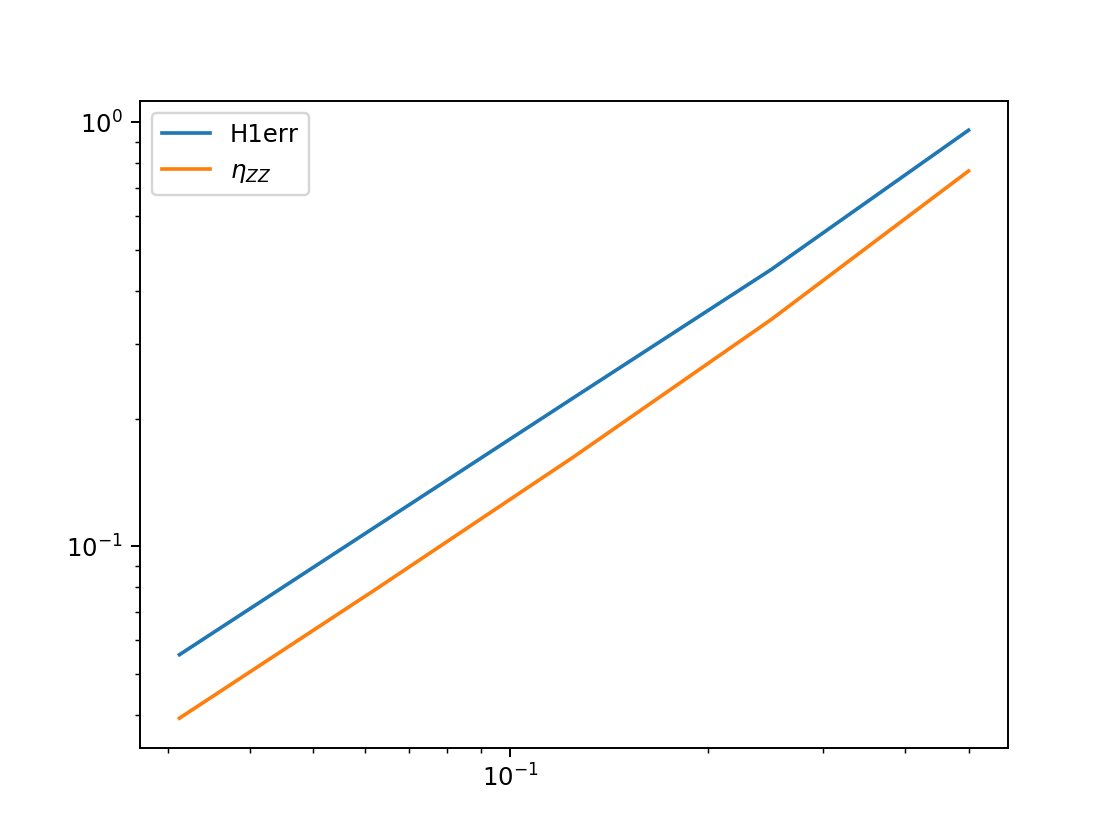

In [56]:
%matplotlib notebook

plt.loglog(maxh, H1err_arr, label = "H1err")
plt.loglog(maxh, eta_arr, label = "$\eta_{ZZ}$")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


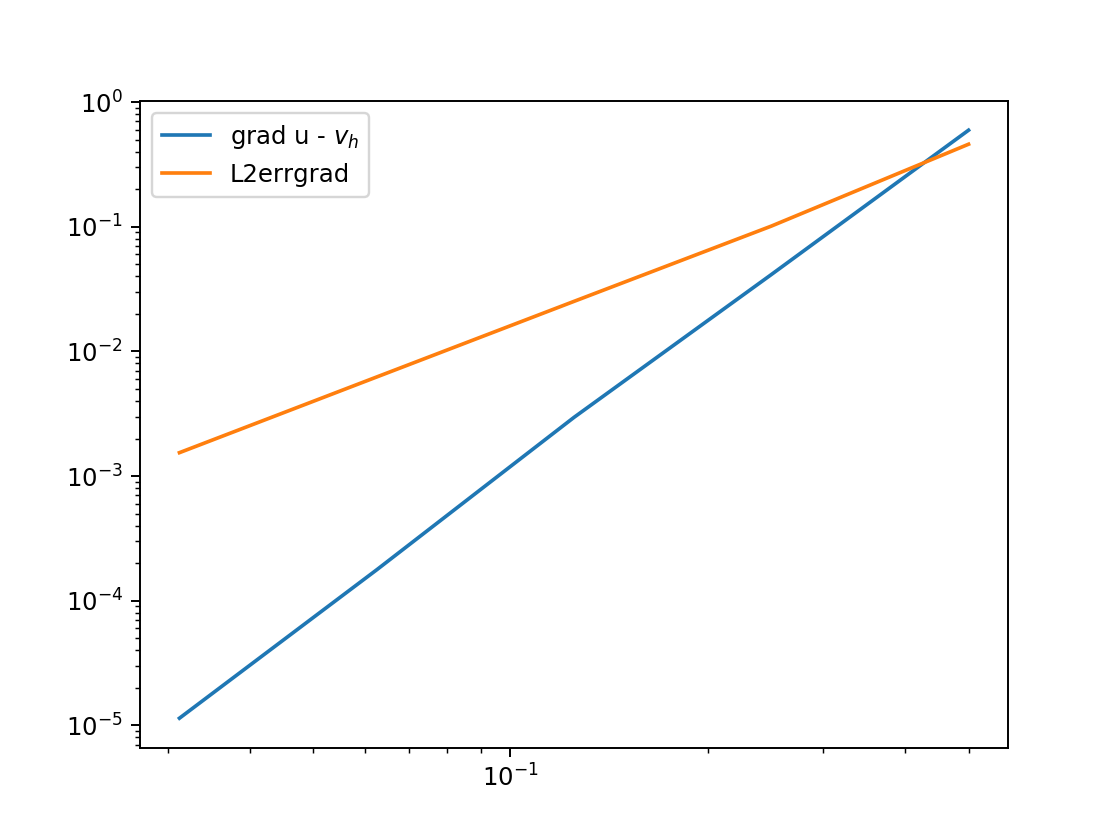

In [44]:
%matplotlib notebook
   
plt.loglog(maxh, alph_arr, label = "grad u - $v_h$")
plt.loglog(maxh, L2errgrad_arr, label = "L2errgrad")


plt.legend()
plt.show()